<h1>Links to datasets</h1>

Link to dataset: https://www.kaggle.com/code/egenius/starter-cert-insider-threat-cfc11c55-1/input

Alternative dataset: https://www.kaggle.com/datasets/mrajaxnp/cert-insider-threat-detection-research/data?select=http.csv

<h1>Imported Libraries</h1>

In [239]:
# Basic Libraries
import pandas as pd
import re
import string
import numpy as np
import nltk
from scipy import stats
import warnings


# NLP Tools
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from textblob import TextBlob

# Data Preprocessing
from sklearn.preprocessing import StandardScaler

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Models and Metrics
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, VotingClassifier, IsolationForest
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, recall_score, f1_score, classification_report, mean_squared_error
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV

# Download required NLTK data (only need to do this once)
nltk.download('punkt')
nltk.download('stopwords')
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\OnilChibaya\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\OnilChibaya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<h1>Preprocessing</h1>

<h4>Import Dataset</h4>

In [240]:
dataset = pd.read_csv('email.csv')
# dataset.head()

For testing perposes. 

In [241]:
dataset = dataset.head(10000)
#dataset

<h2>Pre-preprocessing</h2>

Split the 'datetime' column into 'date' and 'time' columns

In [242]:
# Split the 'datetime' column into 'date' and 'time' columns
split_df = dataset['date'].str.split(' ', expand=True)
dataset['date'] = split_df[0]
dataset['time'] = split_df[1].fillna('00:00:00')  # Fill missing time values with a default time if needed
# dataset.head()

Convert email addresses to the number of addresses in each row

In [243]:
# Convert email addresses to the number of addresses in each row
dataset['to'] = dataset['to'].str.count(';') + 1
# dataset.head()

Convert cc addresses to the number of addresses in each row

In [244]:
# Convert cc addresses to the number of addresses in each row
dataset['cc'] = dataset['cc'].apply(lambda x: x.count(';') + 1 if pd.notna(x) else 0)
# dataset.head()

Convert bcc addresses to the number of addresses in each row

In [245]:
# Convert bcc addresses to the number of addresses in each row
dataset['bcc'] = dataset['bcc'].apply(lambda x: x.count(';') + 1 if pd.notna(x) else 0)
# dataset.head()

Convert the text in 'from' to lowercase

In [246]:
# Convert the text in 'from' to lowercase
dataset['from'] = dataset['from'].str.lower()
# dataset.head()

Rearrange columns

In [247]:
# Rearrange columns
dataset = dataset[['id', 'pc', 'user', 'date', 'time', 'from', 'to', 'cc', 'bcc', 'size', 'attachments', 'content']]
dataset.head()

,id,pc,user,date,time,from,to,cc,bcc,size,attachments,content
0,{R3I7-S4TX96FG-8219JWFF},PC-5758,LAP0338,01/02/2010,07:11:45,lynn.adena.pratt@dtaa.com,2,1,0,25830,0,middle f2 systems 4 july techniques powerful d...
1,{R0R9-E4GL59IK-2907OSWJ},PC-6699,MOH0273,01/02/2010,07:12:16,moh68@optonline.net,1,0,0,29942,0,the breaking called allied reservations former...
2,{G2B2-A8XY58CP-2847ZJZL},PC-5758,LAP0338,01/02/2010,07:13:00,lynn_a_pratt@earthlink.net,1,0,0,28780,0,slowly this uncinus winter beneath addition ex...
3,{A3A9-F4TH89AA-8318GFGK},PC-5758,LAP0338,01/02/2010,07:13:17,lynn_a_pratt@earthlink.net,1,0,0,21907,0,400 other difficult land cirrocumulus powered ...
4,{E8B7-C8FZ88UF-2946RUQQ},PC-6699,MOH0273,01/02/2010,07:13:28,moh68@optonline.net,3,0,1,17319,0,this kmh october holliswood number advised unu...


<h1>Preprocessing</h1>

convert date and time to numerical data for the standardization and normalization process.

In [248]:
# Remove '/' from the 'date'
dataset['date'] = dataset['date'].str.replace('/', '')
# dataset.head()

Remove ':' from the 'time'

In [249]:
# Remove ':' from the 'time'
dataset['time'] = dataset['time'].str.replace(':', '')
# dataset.head()

Converting the PC- column to niumeric by removing the PC- string and keeping the PC value only.

In [250]:
# Remove the "PC-" prefix
dataset['pc'] = dataset['pc'].str.replace('PC-', '')
# dataset.head()

Rearrange columns

In [251]:
# Rearrange columns
dataset = dataset[['id', 'user', 'from', 'pc','date', 'time', 'to', 'cc', 'bcc', 'size', 'attachments', 'content']]
# dataset.head()

Feature Engineering

In [252]:
# Character Count
dataset['char_count'] = dataset['content'].apply(len)

# Word Count
dataset['word_count'] = dataset['content'].apply(lambda x: len(x.split()))

# Average Word Length
dataset['avg_word_length'] = dataset['content'].apply(lambda x: sum(len(word) for word in x.split()) / len(x.split()) if len(x.split()) > 0 else 0)

# Counting the number of sentences
dataset['sentence_count'] = dataset['content'].apply(lambda x: len(sent_tokenize(x)))

In [253]:
# Rearrange columns
dataset = dataset[['id', 'user', 'from', 'pc','date', 'time', 'to', 'cc', 'bcc', 'size', 'attachments', 'char_count', 'word_count', 'avg_word_length', 'sentence_count', 'content']]
# dataset.head()

<h5>Standardization</h5>

Before standardizing the data, we have to convert the pc, date and time varialbles to type int64

In [254]:
# Convert column 'pc', 'date' and time to int64
dataset['pc'] = dataset['pc'].astype('int64')

dataset['date'] = dataset['date'].astype('int64')

dataset['time'] = dataset['time'].astype('int64')
# dataset.head()

Identify and Standardize numeric columns

In [255]:
# Identify numeric columns
numeric_columns = dataset.select_dtypes(include=['float64', 'int64']).columns

# Standardize numeric columns
scaler = StandardScaler()
dataset[numeric_columns] = scaler.fit_transform(dataset[numeric_columns])
# dataset.head()

<h1>Identify numerical anomalies</h1>

We calculate the z-scores, identify whether there are anomalies or not with a threshold of 2. We then extract the anomaloes and separate the two datasets into on contaning anomalies and one without.

In [256]:
# Calculate Z-scores
z_scores = stats.zscore(dataset.select_dtypes(include=['float64', 'int64']))

# Get boolean DataFrame indicating the presence of anomalies (using a threshold of 2)
anomalies_bool_df = pd.DataFrame(z_scores, columns=dataset.select_dtypes(include=['float64', 'int64']).columns, index=dataset.index)
anomalies_bool_df = (anomalies_bool_df > 2) | (anomalies_bool_df < -2)

# Extract anomalies
anomalies = dataset[anomalies_bool_df.any(axis=1)]

# Drop anomalies from the original dataset
df_no_anomalies = dataset.drop(anomalies.index)

# Display the datasets
print("Normal Dataset:")
print(df_no_anomalies)
print("\nAnomalous Dataset:")
print(anomalies)

Normal Dataset:
                            id     user                            from  \
350   {G3V3-K3EF51ED-9738KBOA}  CMB0912       caleb.mason.ball@dtaa.com   
351   {G7D0-V4UY27UY-2315WSCF}  CMB0912       caleb.mason.ball@dtaa.com   
352   {Q1Z5-B8YS10HL-0266UIJH}  CMB0912       caleb.mason.ball@dtaa.com   
354   {P8K9-E2TI65VM-0282FINH}  CMB0912       caleb.mason.ball@dtaa.com   
355   {S5S1-I2ZY13YH-0203IGWX}  CMB0912       caleb.mason.ball@dtaa.com   
...                        ...      ...                             ...   
9994  {D8E7-G4SC72JK-7248JMXD}  LOM0086                 lom415@juno.com   
9995  {L9O3-C6RO47MB-7461QDKZ}  BTL0226  bernard.tobias.landry@dtaa.com   
9996  {D5T8-U8YU31FA-3113KYJP}  JNA0559        justine.n.adkins@msn.com   
9997  {J1E1-Y5UN67AC-5798OAKF}  BTL0226  bernard.tobias.landry@dtaa.com   
9999  {D6H5-C9TD28IR-9205PZTZ}  JCC0225     jack.carlos.cannon@dtaa.com   

            pc      date      time        to        cc       bcc      size  \
350  

Here we combine the two dataframes after adding the numeric_anomalies column. The column contains values, either 1 or 0 where 1 indicates that there are anomalies in the dataset and 0 indicates that there are no anomalies in the dataset.

In [257]:
df_no_anomalies['numeric_anomalies'] = 0
anomalies['numeric_anomalies'] = 1
# Combine dataframes vertically
dataset = pd.concat([df_no_anomalies, anomalies])

# Order by index
dataset = dataset.sort_index()
# dataset.head()

<h1>Text Pre-processing</h1>

Convert the text in 'content' to lowercase

In [258]:
# Convert the text in 'content' to lowercase
dataset['content'] = dataset['content'].str.lower()
# dataset.head()

Below is a function used to preprocess the email content in the 'content' column. We start by tokenizing the content of the email, removing stop words and then stemming the content using the python PorterStemmer() function.

In [259]:
def preprocess_email_content(email):
    # Tokenization
    tokens = word_tokenize(email)

    # Removal of stop words
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [token for token in tokens if token.lower() not in stop_words]

    # Stemming
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(token) for token in filtered_tokens]

    return ' '.join(stemmed_tokens)

Apply preprocessing to the 'content' column

In [260]:
# Apply preprocessing to the 'content' column
dataset['content'] = dataset['content'].apply(preprocess_email_content)

<h1>Detect Sentiment Anomalies</h1>

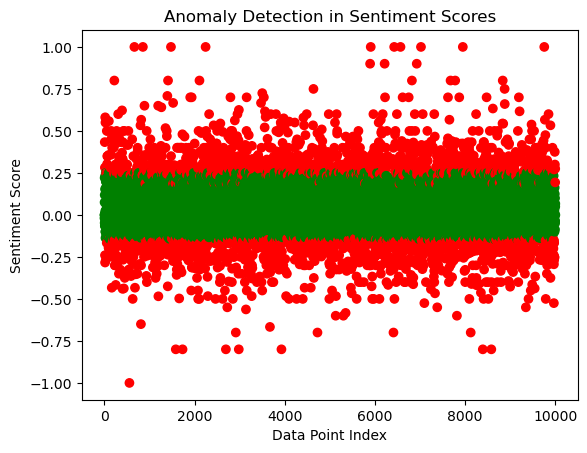

In [263]:
# Perform sentiment analysis and get polarity scores
dataset['sentiment_score'] = dataset['content'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Detect anomalies using Isolation Forest
clf = IsolationForest(contamination=0.2)
dataset['sentiment_anomaly'] = clf.fit_predict(dataset[['sentiment_score']])

# Create a color map based on the 'sentiment_anomaly' values
colors = dataset['sentiment_anomaly'].apply(lambda x: 'red' if x == -1 else 'green')

# Plot sentiment scores and anomalies
plt.scatter(dataset.index, dataset['sentiment_score'], c=colors)
plt.xlabel('Data Point Index')
plt.ylabel('Sentiment Score')
plt.title('Anomaly Detection in Sentiment Scores')
plt.show()

<h1>Feature Engineering</h1>

Replace all occurrences of 1 with 0 in 'sentiment_anomaly' and then all occurrences of -1 with 1 in the same column.

In [265]:
# Replace all occurrences of 1 with 0 in 'sentiment_anomaly' and then all occurrences of -1 with 1 in the same column.
dataset['sentiment_anomaly'] = dataset['sentiment_anomaly'].replace(1, 0)
dataset['sentiment_anomaly'] = dataset['sentiment_anomaly'].replace(-1, 1)
# dataset.head()

Creating the 'target' value.

In [266]:
# Add the 'target' column
dataset['target'] = dataset['numeric_anomalies'] + dataset['sentiment_anomaly']
dataset.loc[dataset['target'] == 2, 'target'] = 1
# dataset.head()

Identifying and Standardizing new numeric columns.

In [267]:
# Identify numeric columns
numeric_columns = ['numeric_anomalies', 'sentiment_score', 'sentiment_anomaly']

# Standardize numeric columns
scaler = StandardScaler()
dataset[numeric_columns] = scaler.fit_transform(dataset[numeric_columns])
# dataset.head()

Rearrange columns

In [268]:
# Rearrange columns
dataset = dataset[['id', 'user', 'from', 'pc','date', 'time', 'to', 'cc', 'bcc', 'size', 'attachments', 'char_count', 'word_count', 'avg_word_length', 'sentence_count', 'sentiment_score', 'numeric_anomalies', 'sentiment_anomaly','content', 'target']]
dataset.head()

,id,user,from,pc,date,time,to,cc,bcc,size,attachments,char_count,word_count,avg_word_length,sentence_count,sentiment_score,numeric_anomalies,sentiment_anomaly,content,target
0,{R3I7-S4TX96FG-8219JWFF},LAP0338,lynn.adena.pratt@dtaa.com,0.236604,-3.620189,-1.458712,0.374907,0.564493,-0.462960,-0.412598,-0.446829,0.833314,1.349865,-1.257487,0.0,-0.339811,1.633517,-0.497968,middl f2 system 4 juli techniqu power destroy ...,1
1,{R0R9-E4GL59IK-2907OSWJ},MOH0273,moh68@optonline.net,0.555247,-3.620189,-1.456523,-0.734614,-0.868230,-0.462960,0.001289,-0.446829,-0.615704,-0.651180,0.034313,0.0,-0.225805,1.633517,-0.497968,break call alli reserv former victori casualti...,1
2,{G2B2-A8XY58CP-2847ZJZL},LAP0338,lynn_a_pratt@earthlink.net,0.236604,-3.620189,-1.453934,-0.734614,-0.868230,-0.462960,-0.115670,-0.446829,-0.991375,-0.951337,-0.341468,0.0,-0.225805,1.633517,-0.497968,slowli uncinu winter beneath addit exist power...,1
3,{A3A9-F4TH89AA-8318GFGK},LAP0338,lynn_a_pratt@earthlink.net,0.236604,-3.620189,-1.453410,-0.734614,-0.868230,-0.462960,-0.807461,-0.446829,0.081971,-0.050867,0.459395,0.0,0.223095,1.633517,-0.497968,400 difficult land cirrocumulu power probabl e...,1
4,{E8B7-C8FZ88UF-2946RUQQ},MOH0273,moh68@optonline.net,0.555247,-3.620189,-1.453070,1.484428,-0.868230,1.907547,-1.269259,-0.446829,0.149056,0.049186,0.351043,0.0,1.095955,1.633517,-0.497968,kmh octob holliswood number advis unusu crew a...,1


<h1>Feature Selection</h1>

Below is a heatmap of the feature correlation. The heatmap below is used to visualize which of the feature in our dataset influence the target variable the most.

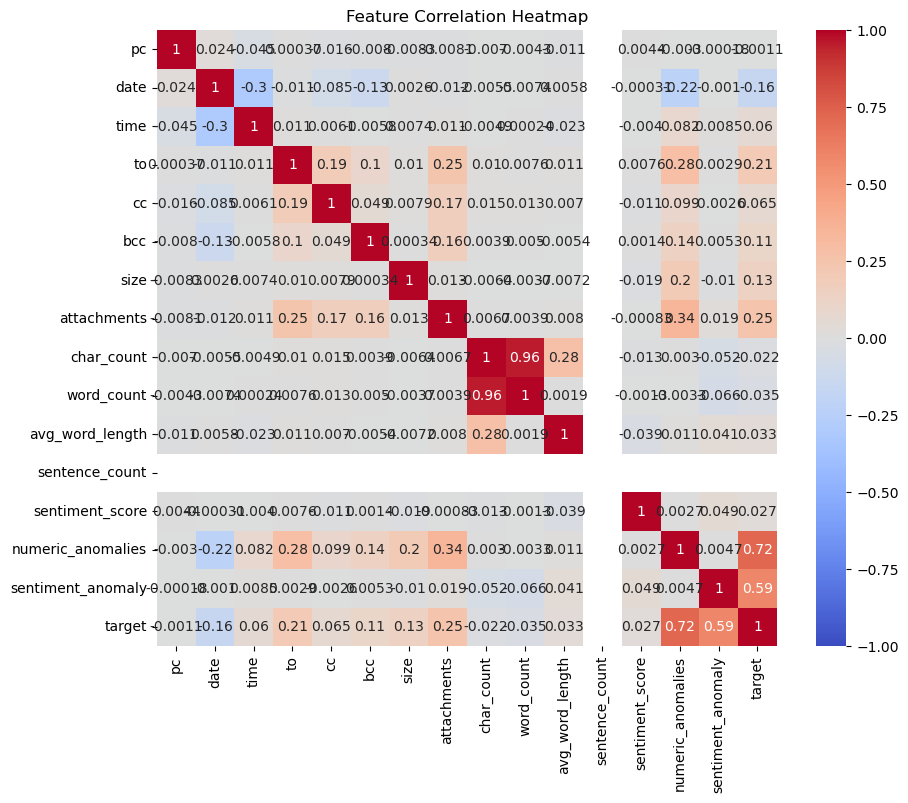

In [269]:
# Compute the correlation matrix
corr = dataset.corr()

# Generate a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)

# Display the heatmap
plt.title("Feature Correlation Heatmap")
plt.show()

Below are some Feature Selection methods.

- Filter Method: We identify features that are highly correlated (here I used a threshold of 0.8) and remove them since they might carry redundant information.

- Wrapper Method: Using RFE, we wrap around a model (in this case, LinearRegression) to rank features based on their importance in predicting the target. Here, we're selecting 5 top features.

- Embedded Method: We utilize a RandomForest model to compute feature importances and select features that have an importance score above the mean.

Each method will likely produce a different subset of features. The best set often depends on the problem and the model you're planning to use. Testing the performance of your machine learning model with each subset will provide more insights into which features to finally select.

In [270]:
dataset = dataset[['pc','date', 'time', 'to', 'cc', 'bcc', 'size', 'attachments', 'char_count', 'word_count', 'avg_word_length', 'sentence_count', 'sentiment_score', 'numeric_anomalies', 'sentiment_anomaly', 'target']]
X = dataset.drop('target', axis=1)  # Features
y = dataset['target']  # Target variable (0 for normal, 1 for insider threat)
feature_names = X.columns  # This is the corrected line

# 1. Filter Method
# Removing features with high correlation
correlation_matrix = pd.DataFrame(X, columns=feature_names).abs()
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
features_to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] < 0.8)]
X_filtered = pd.DataFrame(X, columns=feature_names).drop(features_to_drop, axis=1)

# 2. Wrapper Method
# Recursive Feature Elimination
estimator = LinearRegression()
selector = RFE(estimator=estimator, n_features_to_select=5, step=1)
selector = selector.fit(X, y)
selected_features_wrapper = np.array(feature_names)[selector.support_]

# 3. Embedded Method
# Feature importances from Random Forest
model = RandomForestRegressor(n_estimators=100)
model.fit(X, y)
importances = model.feature_importances_
selected_features_embedded = np.array(feature_names)[importances > np.mean(importances)]

print("Features selected by Filter method:", list(X_filtered.columns))
print("Features selected by Wrapper method:", list(selected_features_wrapper))
print("Features selected by Embedded method:", list(selected_features_embedded))

Features selected by Filter method: ['pc', 'date', 'time', 'numeric_anomalies']
Features selected by Wrapper method: ['attachments', 'char_count', 'word_count', 'numeric_anomalies', 'sentiment_anomaly']
Features selected by Embedded method: ['numeric_anomalies', 'sentiment_anomaly']


New dataset of selected Features

In [271]:
dataset = dataset[['pc', 'date', 'time', 'avg_word_length', 'sentence_count', 'numeric_anomalies', 'sentiment_score', 'sentiment_anomaly','target']]
# dataset = dataset[['pc', 'date', 'time', 'char_count', 'word_count', 'avg_word_length', 'numeric_anomalies', 'sentiment_anomaly', 'target']]
# dataset = dataset[['pc', 'date', 'time', 'char_count', 'word_count','sentence_count', 'numeric_anomalies', 'sentiment_anomaly', 'target']]
X = dataset.drop('target', axis=1)  # Features
y = dataset['target']  # Target variable (0 for normal, 1 for insider threat)

Below is the updated heatmap of features in correlation to the target value.

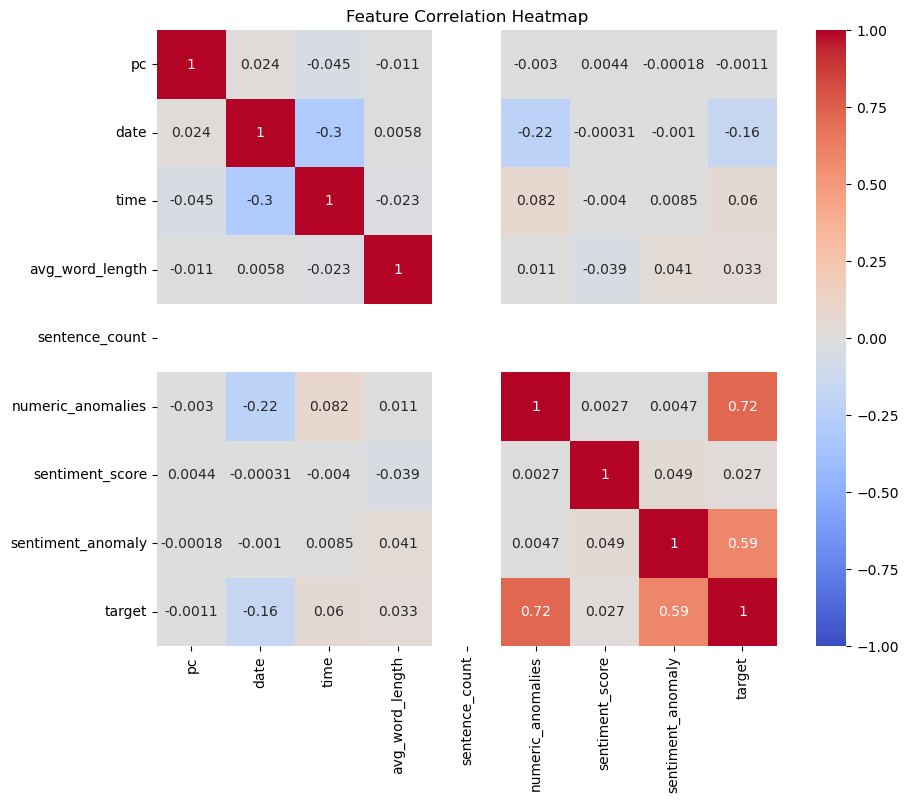

In [272]:
# Compute the correlation matrix
corr = dataset.corr()

# Generate a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)

# Display the heatmap
plt.title("Feature Correlation Heatmap")
plt.show()

<h1>Model training and testing</h1>

Train Test Split

In [ ]:
# Split the data into training and testing sets
X = dataset.drop('target', axis=1)  # Features
y = dataset['target']  # Target variable (0 for normal, 1 for insider threat)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) # split ration 30%

Random Forest

In [273]:
# Create and train a Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Print a classification report for more detailed evaluation
print(classification_report(y_test, y_pred))


Accuracy: 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1164
           1       1.00      1.00      1.00       836

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



SVM Classifier

In [274]:
# Create an SVM classifier without class weights
svm_classifier = SVC(kernel='linear', C=1.0, random_state=42)

# Train the model
svm_classifier.fit(X_train, y_train)

# Make predictions
y_pred = svm_classifier.predict(X_test)

# Calculate accuracy, recall, and F1-score
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)  # Removed average='weighted'
f1 = f1_score(y_test, y_pred)          # Removed average='weighted'

# Print the evaluation metrics
print("SVM Accuracy:", accuracy)
print("SVM Recall:", recall)
print("SVM F1-score:", f1)

SVM Accuracy: 1.0
SVM Recall: 1.0
SVM F1-score: 1.0


SVM for multiclass target values

In [275]:
# Create an SVM classifier without class weights
svm_classifier = SVC(kernel='linear', C=1.0, random_state=42)

# Train the model
svm_classifier.fit(X_train, y_train)

# Make predictions
y_pred = svm_classifier.predict(X_test)

# Calculate accuracy, recall, and F1-score
accuracy = accuracy_score(y_test, y_pred)
recall_per_class = recall_score(y_test, y_pred, average=None)  # Changed to average=None
f1_per_class = f1_score(y_test, y_pred, average=None)          # Changed to average=None

# Print the evaluation metrics
print("SVM Accuracy:", accuracy)
print("SVM Recall per class:", recall_per_class)
print("SVM F1-score per class:", f1_per_class)

SVM Accuracy: 1.0
SVM Recall per class: [1. 1.]
SVM F1-score per class: [1. 1.]


Logistic Regression

In [276]:
# Create a Logistic Regression classifier without class weights
logistic_classifier = LogisticRegression(random_state=42)

# Train the model
logistic_classifier.fit(X_train, y_train)

# Make predictions
y_pred = logistic_classifier.predict(X_test)

# Calculate accuracy, recall, and F1-score
accuracy = accuracy_score(y_test, y_pred)
recall_per_class = recall_score(y_test, y_pred, average=None)  # Removed average='weighted' and set to None
f1_per_class = f1_score(y_test, y_pred, average=None)          # Removed average='weighted' and set to None

# Print the evaluation metrics
print("Logistic Regression Accuracy:", accuracy)
print("Logistic Regression Recall per class:", recall_per_class)
print("Logistic Regression F1-score per class:", f1_per_class)

Logistic Regression Accuracy: 1.0
Logistic Regression Recall per class: [1. 1.]
Logistic Regression F1-score per class: [1. 1.]


Decision Tree

In [277]:
# Create a Decision Tree classifier without class weights
tree_classifier = DecisionTreeClassifier(random_state=42)

# Train the model
tree_classifier.fit(X_train, y_train)

# Make predictions
y_pred = tree_classifier.predict(X_test)

# Calculate accuracy, recall, and F1-score
accuracy = accuracy_score(y_test, y_pred)
recall_per_class = recall_score(y_test, y_pred, average=None)  # Removed average='weighted' and set to None
f1_per_class = f1_score(y_test, y_pred, average=None)          # Removed average='weighted' and set to None

# Print the evaluation metrics
print("Decision Tree Accuracy:", accuracy)
print("Decision Tree Recall per class:", recall_per_class)
print("Decision Tree F1-score per class:", f1_per_class)

Decision Tree Accuracy: 1.0
Decision Tree Recall per class: [1. 1.]
Decision Tree F1-score per class: [1. 1.]


Ensemble model made up of a Random Forest Classifier, SVM Classifier, Logistic Regression Model and Decision Tree Classifier.

In [278]:
# Create individual classifiers without class weights
random_forest = RandomForestClassifier(random_state=42)
svc_classifier = SVC(kernel='linear', C=1.0, probability=True, random_state=42)
logistic_classifier = LogisticRegression(random_state=42)
tree_classifier = DecisionTreeClassifier(random_state=42)

# Create an ensemble classifier using voting
ensemble_classifier = VotingClassifier(estimators=[
    ('rf', random_forest),
    ('svc', svc_classifier),
    ('logistic', logistic_classifier),
    ('tree', tree_classifier)
], voting='soft')  # Use 'soft' voting for probability-based voting

# Train the ensemble model
ensemble_classifier.fit(X_train, y_train)

# Make predictions
y_pred = ensemble_classifier.predict(X_test)

# Evaluate the ensemble model
accuracy = accuracy_score(y_test, y_pred)
recall_per_class = recall_score(y_test, y_pred, average=None)  # Changed to average=None
f1_per_class = f1_score(y_test, y_pred, average=None)          # Changed to average=None

# Print the evaluation metrics
print("Ensemble Accuracy:", accuracy)
print("Ensemble Recall per class:", recall_per_class)
print("Ensemble F1-score per class:", f1_per_class)


Ensemble Accuracy: 1.0
Ensemble Recall per class: [1. 1.]
Ensemble F1-score per class: [1. 1.]


<h1>Cross validation</h1>

K-fold cross-validation

We then performed hyperparemeter tuning and 10-fold cross validation to cater for the overfitting issue through an ensemble model of three models, the code to do so is presented below:

In [279]:
# Define the individual models
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
svc_model = SVC(probability=True, random_state=42)
logreg_model = LogisticRegression(random_state=42)

# Create an ensemble of the models using majority class voting
ensemble_model = VotingClassifier(estimators=[
    ('random_forest', rf_model),
    ('svc', svc_model),
    ('logistic_regression', logreg_model)
], voting='soft')

param_grid_ensemble = {
    'weights': [[1, 1, 1], [2, 1, 1], [1, 2, 1], [1, 1, 2]]
}

# Apply 20-fold cross-validation
grid_search_ensemble = GridSearchCV(ensemble_model, param_grid_ensemble, cv=20)
grid_search_ensemble.fit(X, y)

best_ensemble = grid_search_ensemble.best_estimator_

# Evaluating best ensemble model using 10-fold CV
scores = cross_val_score(best_ensemble, X, y, cv=10)
print(f"Accuracy for each fold: {scores}")
print(f"Average accuracy: {scores.mean()}")

Accuracy for each fold: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Average accuracy: 1.0


<h1>Regularization</h1>

We applied Regularization to try and solve the overfitting issue we encountered.

In [305]:
# Train a simple linear regression model and evaluate its performance
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print(f"Linear Regression MSE: {mean_squared_error(y_test, y_pred)}")

# Train with L1 (Lasso) regularization
lasso = Lasso(alpha=1.0)
lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)
print(f"Lasso Regression MSE: {mean_squared_error(y_test, y_pred_lasso)}")

# Train with L2 (Ridge) regularization
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)
print(f"Ridge Regression MSE: {mean_squared_error(y_test, y_pred_ridge)}")


Linear Regression MSE: 0.46383787382122416
Lasso Regression MSE: 0.24328051562499997
Ridge Regression MSE: 0.4637797582034033


- The Linear Regression and Ridge Regression models have produced predictions that are very close to the actual outcomes in the test data, with the Linear Regression model being almost perfect. This could be a sign of overfitting, especially for the linear regression model.
- The Lasso Regression model, while not as close in its predictions, might be offering a more generalized model that might perform better on truly unseen data or have better interpretability due to its feature selection properties.

As a next step, you might want to further validate these models on different test sets, use cross-validation, or check the model's performance on truly unseen data to confirm the suspicion of overfitting and determine the best model for your use case.

<h1>Model Validation</h1>

Here we validate the model using alternative test data...

Preprocessing

In [281]:
test_dataset = pd.read_csv('email-test.csv')
test_dataset = test_dataset.head(2000)

In [282]:
# Split the 'datetime' column into 'date' and 'time' columns
split_df = test_dataset['date'].str.split(' ', expand=True)
test_dataset['date'] = split_df[0]
test_dataset['time'] = split_df[1].fillna('00:00:00')  # Fill missing time values with a default time if needed
# dataset.head()

In [283]:
# Rearrange columns
test_dataset = test_dataset[['id', 'pc', 'user', 'date', 'time', 'content']]
# dataset.head()

In [284]:
# Remove '/' from the 'date'
test_dataset['date'] = test_dataset['date'].str.replace('/', '')
# dataset.head()

In [285]:
# Remove ':' from the 'time'
test_dataset['time'] = test_dataset['time'].str.replace(':', '')
# dataset.head()

In [286]:
# Remove the "PC-" prefix
test_dataset['pc'] = test_dataset['pc'].str.replace('PC-', '')
# dataset.head()

In [287]:
# Character Count
test_dataset['char_count'] = test_dataset['content'].apply(len)

# Word Count
test_dataset['word_count'] = test_dataset['content'].apply(lambda x: len(x.split()))

# Average Word Length
test_dataset['avg_word_length'] = test_dataset['content'].apply(lambda x: sum(len(word) for word in x.split()) / len(x.split()) if len(x.split()) > 0 else 0)

# Counting the number of sentences
test_dataset['sentence_count'] = test_dataset['content'].apply(lambda x: len(sent_tokenize(x)))

In [288]:
# Rearrange columns
test_dataset = test_dataset[['id', 'user', 'pc','date', 'time', 'char_count', 'word_count', 'avg_word_length', 'sentence_count', 'content']]
# dataset.head()

In [289]:
# Convert column 'pc', 'date' and time to int64
test_dataset['pc'] = test_dataset['pc'].astype('int64')

test_dataset['date'] = test_dataset['date'].astype('int64')

test_dataset['time'] = test_dataset['time'].astype('int64')
# dataset.head()

In [290]:
# Identify numeric columns
numeric_columns = test_dataset.select_dtypes(include=['float64', 'int64']).columns

# Standardize numeric columns
scaler = StandardScaler()
test_dataset[numeric_columns] = scaler.fit_transform(test_dataset[numeric_columns])
# dataset.head()

In [291]:
# Calculate Z-scores
z_scores = stats.zscore(test_dataset.select_dtypes(include=['float64', 'int64']))

# Get boolean DataFrame indicating the presence of anomalies (using a threshold of 2)
anomalies_bool_df = pd.DataFrame(z_scores, columns=test_dataset.select_dtypes(include=['float64', 'int64']).columns, index=test_dataset.index)
anomalies_bool_df = (anomalies_bool_df > 2) | (anomalies_bool_df < -2)

# Extract anomalies
anomalies = test_dataset[anomalies_bool_df.any(axis=1)]

# Drop anomalies from the original dataset
df_no_anomalies = test_dataset.drop(anomalies.index)

# Display the datasets
print("Normal Dataset:")
print(df_no_anomalies)
print("\nAnomalous Dataset:")
print(anomalies)

Normal Dataset:
                            id     user        pc      date      time  \
0     {F3E2-X3MV05YQ-3516SZDT}  SDH2394  0.434895 -1.348201 -0.984859   
1     {I6N1-Z7VL92UY-8715ESKQ}  SDH2394  0.434895 -1.348201 -0.979175   
2     {G4X5-J7MH70FV-8936QVSB}  SDH2394  0.434895 -1.348201 -0.976738   
3     {M2M7-Z5ST21EU-6704NSKO}  SDH2394  0.434895 -1.348201 -0.970873   
4     {R0A9-O9XB25PE-9236MALV}  SDH2394  0.434895 -1.348201 -0.969700   
...                        ...      ...       ...       ...       ...   
1995  {T0T3-Y1US71UE-3112PDWL}  SSL2271  0.927088  1.090878 -0.428719   
1996  {N1V5-U2DR87OQ-5540VXBL}  EYD2871  1.875573  1.090878 -0.428568   
1997  {U0S3-I4FT58PI-6062OXBI}  HCS2401 -0.461176  1.090878 -0.428568   
1998  {M6D2-I7RM58ZX-0119REKJ}  HHF1995 -0.059452  1.090878 -0.428538   
1999  {D9O8-M9DN23QG-7433RGMH}  ILY3152 -0.790381  1.090878 -0.428508   

      char_count  word_count  avg_word_length  sentence_count  \
0      -1.154489   -1.202813         0.819

In [292]:
df_no_anomalies['numeric_anomalies'] = 0
anomalies['numeric_anomalies'] = 1
# Combine dataframes vertically
test_dataset = pd.concat([df_no_anomalies, anomalies])

# Order by index
test_dataset = test_dataset.sort_index()
# test_dataset.head()

In [293]:
# Convert the text in 'content' to lowercase
test_dataset['content'] = test_dataset['content'].str.lower()
# dataset.head()

In [294]:
def preprocess_email_content(email):
    # Tokenization
    tokens = word_tokenize(email)

    # Removal of stop words
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [token for token in tokens if token.lower() not in stop_words]

    # Stemming
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(token) for token in filtered_tokens]

    return ' '.join(stemmed_tokens)

In [295]:
# Apply preprocessing to the 'content' column
test_dataset['content'] = test_dataset['content'].apply(preprocess_email_content)

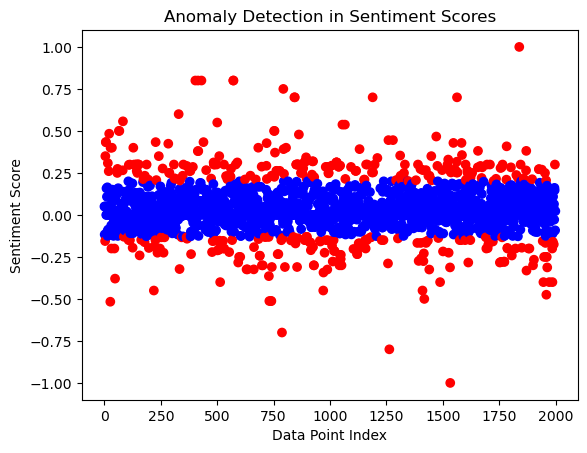

In [296]:
# Perform sentiment analysis and get polarity scores
test_dataset['sentiment_score'] = test_dataset['content'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Detect anomalies using Isolation Forest
clf = IsolationForest(contamination=0.2)
test_dataset['sentiment_anomaly'] = clf.fit_predict(test_dataset[['sentiment_score']])

# Create a color map based on the 'sentiment_anomaly' values
colors = test_dataset['sentiment_anomaly'].apply(lambda x: 'red' if x == -1 else 'blue')

# Plot sentiment scores and anomalies
plt.scatter(test_dataset.index, test_dataset['sentiment_score'], c=colors)
plt.xlabel('Data Point Index')
plt.ylabel('Sentiment Score')
plt.title('Anomaly Detection in Sentiment Scores')
plt.show()

In [297]:
# Identify numeric columns
numeric_columns = ['numeric_anomalies', 'sentiment_score', 'sentiment_anomaly']

# Standardize numeric columns
scaler = StandardScaler()
test_dataset[numeric_columns] = scaler.fit_transform(test_dataset[numeric_columns])
# dataset.head()

Random Forest

In [299]:
# Create and train a Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Alternative test data.
X_test = test_dataset[['pc', 'date', 'time', 'avg_word_length', 'sentence_count', 'numeric_anomalies', 'sentiment_score', 'sentiment_anomaly']]

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Print a classification report for more detailed evaluation
print(classification_report(y_test, y_pred))

Accuracy: 0.56
              precision    recall  f1-score   support

           0       0.59      0.83      0.69      1164
           1       0.43      0.19      0.26       836

    accuracy                           0.56      2000
   macro avg       0.51      0.51      0.47      2000
weighted avg       0.52      0.56      0.51      2000



SVM Classifier

In [300]:
# Create an SVM classifier without class weights
svm_classifier = SVC(kernel='linear', C=1.0, random_state=42)

# Train the model
svm_classifier.fit(X_train, y_train)

# Make predictions
y_pred = svm_classifier.predict(X_test)

# Calculate accuracy, recall, and F1-score
accuracy = accuracy_score(y_test, y_pred)
recall_per_class = recall_score(y_test, y_pred, average=None)  # Changed to average=None
f1_per_class = f1_score(y_test, y_pred, average=None)          # Changed to average=None

# Print the evaluation metrics
print("SVM Accuracy:", accuracy)
print("SVM Recall per class:", recall_per_class)
print("SVM F1-score per class:", f1_per_class)

SVM Accuracy: 0.5585
SVM Recall per class: [0.82646048 0.1854067 ]
SVM F1-score per class: [0.68542928 0.25984912]


Logistic Regression

In [301]:
# Create a Logistic Regression classifier without class weights
logistic_classifier = LogisticRegression(random_state=42)

# Train the model
logistic_classifier.fit(X_train, y_train)

# Make predictions
y_pred = logistic_classifier.predict(X_test)

# Calculate accuracy, recall, and F1-score
accuracy = accuracy_score(y_test, y_pred)
recall_per_class = recall_score(y_test, y_pred, average=None)  # Removed average='weighted' and set to None
f1_per_class = f1_score(y_test, y_pred, average=None)          # Removed average='weighted' and set to None

# Print the evaluation metrics
print("Logistic Regression Accuracy:", accuracy)
print("Logistic Regression Recall per class:", recall_per_class)
print("Logistic Regression F1-score per class:", f1_per_class)

Logistic Regression Accuracy: 0.5585
Logistic Regression Recall per class: [0.82646048 0.1854067 ]
Logistic Regression F1-score per class: [0.68542928 0.25984912]


Decision Tree

In [302]:
# Create a Decision Tree classifier without class weights
tree_classifier = DecisionTreeClassifier(random_state=42)

# Train the model
tree_classifier.fit(X_train, y_train)

# Make predictions
y_pred = tree_classifier.predict(X_test)

# Calculate accuracy, recall, and F1-score
accuracy = accuracy_score(y_test, y_pred)
recall_per_class = recall_score(y_test, y_pred, average=None)  # Removed average='weighted' and set to None
f1_per_class = f1_score(y_test, y_pred, average=None)          # Removed average='weighted' and set to None

# Print the evaluation metrics
print("Decision Tree Accuracy:", accuracy)
print("Decision Tree Recall per class:", recall_per_class)
print("Decision Tree F1-score per class:", f1_per_class)

Decision Tree Accuracy: 0.5585
Decision Tree Recall per class: [0.82646048 0.1854067 ]
Decision Tree F1-score per class: [0.68542928 0.25984912]


Ensemble Classifier

In [303]:
# Create individual classifiers without class weights
random_forest = RandomForestClassifier(random_state=42)
svc_classifier = SVC(kernel='linear', C=1.0, probability=True, random_state=42)
logistic_classifier = LogisticRegression(random_state=42)
tree_classifier = DecisionTreeClassifier(random_state=42)

# Create an ensemble classifier using voting
ensemble_classifier = VotingClassifier(estimators=[
    ('rf', random_forest),
    ('svc', svc_classifier),
    ('logistic', logistic_classifier),
    ('tree', tree_classifier)
], voting='soft')  # Use 'soft' voting for probability-based voting

# Train the ensemble model
ensemble_classifier.fit(X_train, y_train)

# Make predictions
y_pred = ensemble_classifier.predict(X_test)

# Evaluate the ensemble model
accuracy = accuracy_score(y_test, y_pred)
recall_per_class = recall_score(y_test, y_pred, average=None)  # Changed to average=None
f1_per_class = f1_score(y_test, y_pred, average=None)          # Changed to average=None

# Print the evaluation metrics
print("Ensemble Accuracy:", accuracy)
print("Ensemble Recall per class:", recall_per_class)
print("Ensemble F1-score per class:", f1_per_class)

Ensemble Accuracy: 0.5585
Ensemble Recall per class: [0.82646048 0.1854067 ]
Ensemble F1-score per class: [0.68542928 0.25984912]
